# Tutorial for Disjoint Generative Models
In this notebook we show the basic functionality of the DGMs codebase.

### Example 1: Getting started with DGMs

First we do a very rudimentary example of DGMs on a simple dataset. We specify two models ```synthpop``` and ```privbayes``` to each be responsible for one part of the dataset. 

Unless otherwise specified, the dataset manager module will randomly split the dataset into equal parts for each model.

In [1]:
# Imports
import pandas as pd
from disjoint_generative_model import DisjointGenerativeModels

[KeOps] Warning : Cuda libraries were not detected on the system or could not be loaded ; using cpu only mode


In [2]:
# Load the training data
df_train = pd.read_csv('experiments/datasets/heart_train.csv')

# Define DGMs using the Synthpop CART model and PrivBayes BN
dgms = DisjointGenerativeModels(df_train, generative_models=['synthpop', 'privbayes'], prepared_splits='correlated')
df_syn = dgms.fit_generate(num_samples=20)
print(dgms.used_splits)
df_syn.head()

Threshold auto-set to: 0.5647714717363743
{0: ['age', 'cp', 'chol', 'restecg', 'slope', 'thal', 'thalach'], 1: ['sex', 'trestbps', 'fbs', 'exang', 'ca', 'target', 'oldpeak']}


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,47,0,2,114,149,0,1,96,0,1.5,2,2,1,0
1,61,1,3,105,239,0,1,97,1,1.8,1,1,2,0
2,57,1,0,200,192,0,1,126,1,0.0,0,4,1,1
3,60,1,0,200,282,0,0,142,1,2.8,1,0,3,0
4,55,1,0,180,342,0,0,132,1,1.9,2,4,3,0


If we want to specify the split, we can do so by passing a dictionary to the model containing the column names.

```python	
prepared_splits = {
    "part1": ["age", "sex", "cp", "trestbps", "chol"],
    "part2": ["fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
}

dgms = DisjointGenerativeModels(df_train, generative_models=['synthpop', 'privbayes'], prepared_splits=prepared_splits)
```
Alternatively, we can specify the split by passing a dictionary with model names as keys and the corresponding column names as values (note that with this method one cannot specify using the same model for two different partitions).

```python
gms_splits = {
    "synthpop": ["age", "sex", "cp", "trestbps", "chol"],
    "privbayes": ["fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]
}

dgms = DisjointGenerativeModels(df_train, generative_models=gms_splits)
```
Finally, it is also possible to specify the number of equal-sized parts rather than the specific columns in both of the above methods.

e.g. send 2 parts to the synthpop model and 1 part to the PrivBayes model

In [3]:
dgms = DisjointGenerativeModels(df_train, generative_models={'synthpop': 2, 'privbayes': 1}) 
df_syn = dgms.fit_generate(num_samples=5)
 
df_syn

e:\GitHub\disjoint-synthetic-data-generation\disjoint_generative_model\utils\dataset_manager.py:35: UserWarning: Split sizes adjusted to {'split0': 10, 'split1': 4}
  warnings.warn(f"Split sizes adjusted to {split_sizes}")


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,60,1,0,160,269,1,0,120,1,2.8,1,1,3,0
1,56,1,2,150,240,1,1,123,1,0.6,1,0,3,1
2,77,1,0,150,289,0,0,133,1,0.6,1,1,1,0
3,61,0,2,160,394,0,0,133,0,0.8,2,0,2,1
4,70,1,3,200,303,0,1,122,0,3.6,1,2,3,0


Note that we get a ```UserWarning``` since a perfect 2:1 split ratio is not achievable (i.e. 14 is not divisible by 3).

Finally, we can also import the method used for randomly splitting the dataset and use it to split the dataset ourselves. This is helpful if we want to use the same split for multiple models, but we don't want to specify the split manually.

In [4]:
from disjoint_generative_model.utils.dataset_manager import random_split_columns

random_split = random_split_columns(df_train, {'part1': 2, 'part2': 1, 'part3': 1})
random_split

e:\GitHub\disjoint-synthetic-data-generation\disjoint_generative_model\utils\dataset_manager.py:35: UserWarning: Split sizes adjusted to {'part1': 8, 'part2': 3, 'part3': 3}
  warnings.warn(f"Split sizes adjusted to {split_sizes}")


{'part1': ['fbs', 'ca', 'restecg', 'chol', 'cp', 'exang', 'target', 'sex'],
 'part2': ['trestbps', 'thalach', 'thal'],
 'part3': ['age', 'oldpeak', 'slope']}

### Example 2: Joining Strategies

The DGMs framework allows for virtually any sort of joining procedure. In this library the following joining starategies are implemented:

Unsupervised:
- ```Concatenating```: Simply concatenates the synthetic data generated by each model.
- ```RandomJoining```: Same as Concatenating, but shuffles the data before concatenating.

Supervised:
- ```UsingJoiningValidator```: Strategy for joining the synthetic data using a validator model. The validator model can use two different adapters ```JoiningValidator``` and ```OneClassValidator```, the former admits binary classification model backends and the latter one-class/outlier detection models. They assign prediction scores to querry joins on the synthetic samples repeadedly subject to various control parameters. Accepted joins are removed from the pool for the next round. 

The ```UsingJoiningValidator``` strategy has various control parameters that can be overwritten by the user, but for most regular use the ```'behaviour'``` argument acts as a shorthand for selecting pre-configured option sets. The following behaviours are available:
- ```'adaptive'```: The parameters are adjusted during the joining process to get more items, the selection threshold is automatically inferred. 
- ```'standard'```: Inherits the default settings from the ```JoiningValidator``` or ```OneClassValidator``` adapter.
- ```'strict'```: No parameters are changed during the joining process (likely to fail in getting enough good joins, consider adjusting the ```'join_multiplier'``` attribute of the DGMs object).


In [ ]:
# Imports
import pandas as pd

from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator, OneClassValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator

In [ ]:
# Load the training data
df_train = pd.read_csv('experiments/datasets/heart_train.csv')

gms = {'synthpop': 2, 'privbayes': 1}

JS = UsingJoiningValidator()
dgms1 = DisjointGenerativeModels(df_train, gms, joining_strategy=JS)

df_syn1 = dgms1.fit_generate()
df_syn1

e:\GitHub\disjoint-synthetic-data-generation\disjoint_generative_model\utils\dataset_manager.py:35: UserWarning: Split sizes adjusted to {'split0': 10, 'split1': 4}
  warnings.warn(f"Split sizes adjusted to {split_sizes}")


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,59,1,0,138,321,0,0,120,0,0.6,1,0,1,1
1,63,0,2,152,233,0,0,168,0,2.3,1,1,2,1
2,40,1,0,110,265,0,0,103,1,0.4,1,1,2,0
3,52,1,0,101,227,0,1,157,0,0.0,1,2,2,1
4,48,1,1,125,207,0,0,174,0,3.1,1,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,51,1,0,125,215,0,1,168,0,2.8,1,0,3,0
238,64,1,1,125,169,0,1,158,0,0.0,1,0,2,1
239,62,1,1,120,245,0,1,96,1,0.2,1,0,3,0
240,64,0,2,120,160,0,1,138,0,0.0,2,0,2,1


In [ ]:
JS = UsingJoiningValidator(OneClassValidator())
dgms2 = DisjointGenerativeModels(df_train, gms, joining_strategy=JS)

df_syn2 = dgms2.fit_generate()
df_syn2

e:\GitHub\disjoint-synthetic-data-generation\disjoint_generative_model\utils\dataset_manager.py:35: UserWarning: Split sizes adjusted to {'split0': 10, 'split1': 4}
  warnings.warn(f"Split sizes adjusted to {split_sizes}")


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,74,0,0,112,265,0,1,140,0,0.4,2,1,2,1
1,76,1,3,160,288,1,0,150,1,0.8,1,0,3,1
2,53,0,0,120,178,0,0,143,0,0.8,1,0,2,1
3,52,0,2,100,175,1,0,140,0,0.6,2,0,2,1
4,45,1,2,130,234,1,0,171,0,2.0,1,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,63,1,1,200,197,1,0,158,0,4.0,1,0,2,1
238,66,1,0,136,274,0,1,96,1,2.2,0,2,3,0
239,71,0,0,130,197,0,1,126,1,1.6,1,0,2,1
240,59,1,2,160,239,0,0,150,0,3.0,1,0,1,1


In [7]:
from syntheval import SynthEval

### Metrics
metrics = {
    "h_dist"    : {},
    "corr_diff" : {"mixed_corr": True},
    "auroc_diff" : {"model": "rf_cls"},
    "cls_acc"   : {"F1_type": "macro"},
    "eps_risk"  : {},
    "dcr"       : {},
    "mia"  : {"num_eval_iter": 5},
}

df_train = pd.read_csv('experiments/datasets/heart_train.csv')
df_test = pd.read_csv('experiments/datasets/heart_test.csv')

SE = SynthEval(df_train, df_test)
res, _ = SE.benchmark({'occls': df_syn1, 'cls': df_syn2}, analysis_target_var="target",rank_strategy='summation', **metrics)

res

SynthEval: inferred categorical columns...


avg_h_dist           corr_mat_diff           auroc       cls_F1_diff  \
             value     error         value error     value error       value   
dataset                                                                        
occls     0.076695  0.025107      1.284948   NaN  0.040047   NaN    0.044697   
cls       0.035389  0.012471      0.594695   NaN  0.052612   NaN    0.021893   

                  cls_F1_diff_hout            ... median_DCR       mia_recall  \
            error            value     error  ...      value error      value   
dataset                                       ...                               
occls    0.017128         0.077073   0.01588  ...   0.925389   NaN      0.475   
cls      0.016232         0.070182  0.010184  ...   1.104452   NaN      0.475   

                  mia_precision                rank    u_rank    p_rank f_rank  
            error         value     error                                       
dataset                                                                         
occls    0.067315      0.520483  0.054529  8.224302  4.747368  3.476933    0.0  
cls       0.04239       0.55641  0.035483  8.230142   4.81339  3.416751    0.0  

[2 rows x 24 columns]

In [1]:
# Imports
import pandas as pd

from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator, OneClassValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator

df_train = pd.read_csv('experiments/datasets/heart_train.csv')

gms = {'synthpop': 2, 'privbayes': 1}

JS = UsingJoiningValidator(OneClassValidator(), behaviour='adaptive')
dgms2 = DisjointGenerativeModels(df_train, gms, joining_strategy=JS)

df_syn2 = dgms2.fit_generate()
df_syn2

e:\GitHub\disjoint-synthetic-data-generation\disjoint_generative_model\utils\dataset_manager.py:35: UserWarning: Split sizes adjusted to {'split0': 10, 'split1': 4}
  warnings.warn(f"Split sizes adjusted to {split_sizes}")


Bad joins found F1: [0.44680851063829785, 0.45569620253164556, 0.5609756097560976, 0.4943820224719101, 0.3855421686746988]
Mean F1: 0.46868090281452995
Final model trained!
Threshold auto-set to: -0.45309948008843137
Predicted good joins fraction: 0.10055096418732783
Predicted good joins fraction: 0.05972434915773354
Predicted good joins fraction: 0.05537459283387622
Predicted good joins fraction: 0.02586206896551724
Predicted good joins fraction: 0.017699115044247787
Predicted good joins fraction: 0.016216216216216217
Predicted good joins fraction: 0.018315018315018316
Predicted good joins fraction: 0.016791044776119403
Predicted good joins fraction: 0.011385199240986717
Predicted good joins fraction: 0.013435700575815739
Predicted good joins fraction: 0.01556420233463035
Predicted good joins fraction: 0.009881422924901186
Predicted good joins fraction: 0.005988023952095809
Predicted good joins fraction: 0.002008032128514056
Predicted good joins fraction: 0.006036217303822937
Predicte

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,42,0,1,130,284,0,0,170,0,0.0,2,0,2,1
1,53,0,1,130,196,0,0,165,0,0.0,2,0,2,1
2,41,1,2,160,234,0,0,177,0,0.0,1,0,2,1
3,43,1,2,130,282,0,0,175,0,0.6,2,0,2,1
4,60,1,0,130,252,0,0,174,0,1.4,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,40,1,1,140,203,0,1,143,0,0.0,2,0,3,1
238,66,1,0,122,214,0,0,139,1,2.0,2,1,3,0
239,45,0,2,128,196,0,0,169,0,0.0,2,1,2,1
240,39,1,1,123,214,0,1,163,0,0.6,1,0,3,1


# Cls acc anomaly

In [4]:
import pandas as pd
from sklearn.datasets import make_blobs

X1 = make_blobs(n_samples=250, n_features=6, centers=3, random_state=42)[0]
X1 = pd.DataFrame(X1, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])

X2 = X1.copy()
X2 = X2.multiply([-1, 2, 4, 1.5, 3, 6], axis=1)
X2.columns = ['x7', 'x8', 'x9', 'x10', 'x11', 'x12']

df = pd.concat([X1, X2], axis=1).reset_index(drop=True)

df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index)
df_test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12
1,-2.980236,9.246336,3.191794,0.565706,-7.598071,-7.093557,2.980236,18.492672,12.767178,0.848559,-22.794214,-42.561340
14,6.754228,-7.087243,-6.964868,-6.012128,-5.508149,0.935603,-6.754228,-14.174487,-27.859473,-9.018192,-16.524447,5.613620
20,6.849952,-4.702563,-5.257975,-5.144879,-3.276425,-0.647876,-6.849952,-9.405127,-21.031899,-7.717319,-9.829275,-3.887258
21,-4.234115,8.451999,3.627048,2.287417,-7.787651,-8.292413,4.234115,16.903997,14.508191,3.431126,-23.362954,-49.754480
37,-3.615533,7.818080,5.452405,3.329410,-6.951637,-5.876577,3.615533,15.636159,21.809619,4.994115,-20.854912,-35.259460


In [11]:
import numpy as np
import pandas as pd
from itertools import cycle
from sklearn.cluster import SpectralClustering

def separate_into_buckets(data: pd.DataFrame, n_buckets: int):
    corr_matrix = data.corr().abs()  # Absolute correlation matrix
    np.fill_diagonal(corr_matrix.values, 0)  # Remove self-correlations
    
    # Apply Spectral Clustering to separate correlated features
    clustering = SpectralClustering(n_clusters=n_buckets, affinity='precomputed', assign_labels='kmeans', random_state=42)
    labels = clustering.fit_predict(1 - corr_matrix)  # Convert correlation to distance

    # Collect features by cluster
    clusters = {}
    for feature, cluster in zip(data.columns, labels):
        clusters.setdefault(cluster, []).append(feature)
    
    # Redistribute features into approximately equal-sized buckets
    sorted_clusters = sorted(clusters.values(), key=len, reverse=True)
    buckets = {i: [] for i in range(n_buckets)}
    bucket_cycle = cycle(range(n_buckets))  # Cyclic iterator to distribute features
    
    for cluster in sorted_clusters:
        for feature in cluster:
            buckets[next(bucket_cycle)].append(feature)
    
    return buckets

buckets = separate_into_buckets(df, 5)
print(buckets)

{0: ['x3', 'x2', 'x7'], 1: ['x5', 'x4', 'x9'], 2: ['x8', 'x6'], 3: ['x10', 'x11'], 4: ['x12', 'x1']}


In [45]:
import numpy as np
# even simpler dataset to also check uncorrelated attribute combinations

x1 = np.random.rand(250)
x2 = np.random.rand(250)
X1 = pd.DataFrame({'x1': x1, 'x2': x2})

x3 = 2*x1
x4 = -3*x2
X2 = pd.DataFrame({'x3': x3, 'x4': x4})

df = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'x4': x4})

df_train = df.sample(frac=0.8, random_state=42)
df_test = df.drop(df_train.index)
df_train.head()

,x1,x2,x3,x4
142,0.392002,0.277315,0.784003,-0.831944
6,0.001262,0.995826,0.002524,-2.987478
97,0.138858,0.996079,0.277715,-2.988236
60,0.847913,0.434137,1.695825,-1.302410
112,0.908772,0.543348,1.817545,-1.630045


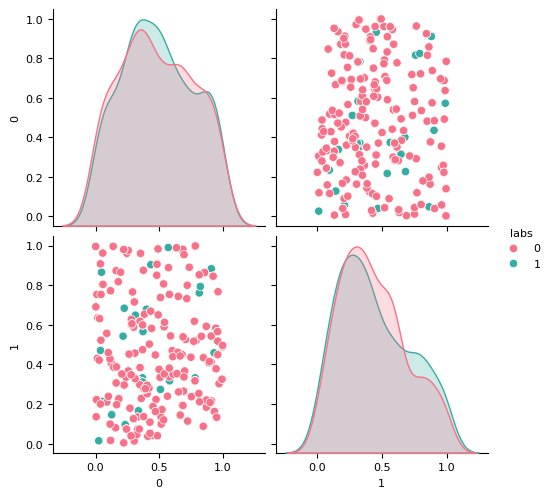

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

from disjoint_generative_model.utils.joining_validator import _setup_training_data

data, labs = _setup_training_data({'part1': df_train[X1.columns], 'part2': df_train[X2.columns]})
data['labs'] = labs

sns.pairplot(data[[0, 1, 'labs']], hue='labs', palette='husl', diag_kind='kde')
plt.show()

Validator: Grid search for hyperparameters
Validator: Best score 0.731405 using {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 10}
Validator: Calibration did not improve the model. Using the original model.
{0: ['age', 'cp', 'chol', 'restecg', 'slope', 'thal', 'thalach'], 1: ['sex', 'trestbps', 'fbs', 'exang', 'ca', 'target', 'oldpeak']}


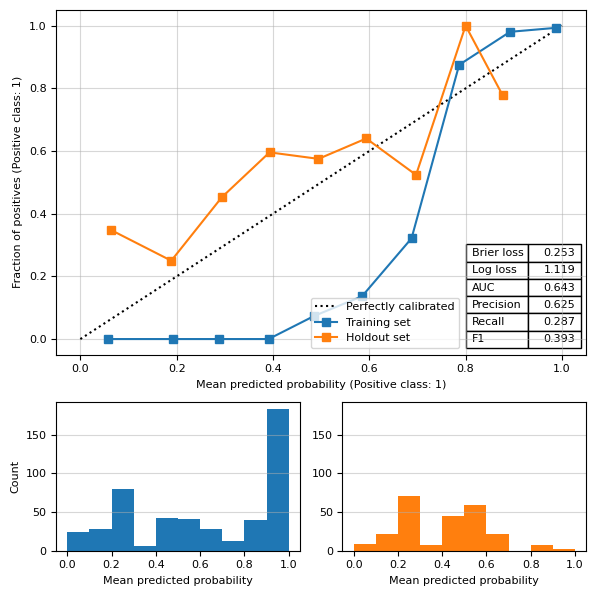

In [20]:
from sklearn.ensemble import RandomForestClassifier

from disjoint_generative_model import DisjointGenerativeModels
from disjoint_generative_model.utils.joining_validator import JoiningValidator
from disjoint_generative_model.utils.joining_strategies import UsingJoiningValidator, Concatenating

df_train = pd.read_csv('experiments/datasets/heart_train.csv')
df_test = pd.read_csv('experiments/datasets/heart_test.csv')

cat_atts = df_train.select_dtypes(include='object').columns.tolist()

for att in [att for att in df_train.columns if att not in cat_atts]:
    if len(df_train[att].unique()) <= 5:
        cat_atts.append(att)

num_atts = [att for att in df_train.columns if att not in cat_atts]

def optimise_model(validator_model, parameter_grid, calibration_method):
    JS = JoiningValidator(validator_model, parameter_grid, calibration_method, verbose=True)
    JV = UsingJoiningValidator(JS)
    dgms = DisjointGenerativeModels(df_train, ['mod1', 'mod2'], 
                                    prepared_splits='correlated', #{"part1": cat_atts, 'part2': num_atts},#
                                    joining_strategy=JV)
    dgms.num_samples = 20
    dgms._setup()
    print(dgms.used_splits)

    dgms._make_calibration_plot(df_test, save=False, stats=True)
    return dgms

model = optimise_model(
    validator_model=RandomForestClassifier(),
    parameter_grid={
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10, 20],
        'criterion': ['gini', 'entropy'],
    },
    calibration_method='sigmoid',
)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

from disjoint_generative_model.utils.joining_validator import _setup_training_data

data, labs = _setup_training_data({'part1': df_train[cat_atts], 'part2': df_train[num_atts]})

knn = RandomForestClassifier()
knn.fit(data, labs)

# Evaluate the model
data, labs = _setup_training_data({'part1': df_train[cat_atts], 'part2': df_train[num_atts]})

y_pred = knn.predict(data)
y_pred_proba = knn.predict_proba(data)[:, 1]

f1 = f1_score(labs, y_pred, average='macro')
roc_auc = roc_auc_score(labs, y_pred_proba)
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

F1 Score: 0.9749843652282677
ROC AUC Score: 0.999178125


In [23]:
from syntheval import SynthEval

from disjoint_generative_model.utils.generative_model_adapters import generate_synthetic_data

df_train = pd.read_csv('experiments/datasets/heart_train.csv')
df_test = pd.read_csv('experiments/datasets/heart_test.csv')

df_baseline = generate_synthetic_data(df_train, 'synthpop')

validator_model = RandomForestClassifier(criterion='gini', max_depth=None, n_estimators=50)
JV = UsingJoiningValidator(JoiningValidator(validator_model, None, 'sigmoid', save_proba=True))
dgms = DisjointGenerativeModels(df_train, ['synthpop', 'dpgan'], 'correlated', joining_strategy=JV)
df_syn_val = dgms.fit_generate()

cat_atts = df_train.select_dtypes(include='object').columns.tolist()

for att in [att for att in df_train.columns if att not in cat_atts]:
    if len(df_train[att].unique()) <= 5:
        cat_atts.append(att)

num_atts = [att for att in df_train.columns if att not in cat_atts]

validator_model = RandomForestClassifier(criterion='entropy', max_depth=None, n_estimators=100)
JV = UsingJoiningValidator(JoiningValidator(validator_model, None, 'sigmoid', save_proba=True))
dgms = DisjointGenerativeModels(df_train, ['synthpop', 'dpgan'], {'part1': cat_atts, 'part2': num_atts}, joining_strategy=JV)
df_syn_val_uncor = dgms.fit_generate()

dgms = DisjointGenerativeModels(df_train, ['synthpop', 'dpgan'], {'part1': cat_atts, 'part2': num_atts}, joining_strategy=Concatenating())
df_syn_con = dgms.fit_generate()

SE = SynthEval(df_train, df_test)
res, _ = SE.benchmark({'baseline': df_baseline, 'dgms_con': df_syn_con, 'dgms_val_cor': df_syn_val, 'dgms_val_nums_cat': df_syn_val_uncor}, analysis_target_var='target', rank_strategy='summation', corr_diff={}, pca={}, eps_risk={})
res

Validator: No search parameters specified. Using default configuration.
Validator: Calibration did not improve the model. Using the original model.
Threshold auto-set to: 0.52
Predicted good joins fraction: 0.11570247933884298
Predicted good joins fraction: 0.10903426791277258
Predicted good joins fraction: 0.06118881118881119
Predicted good joins fraction: 0.0633147113594041
Predicted good joins fraction: 0.05964214711729622
Validator: No search parameters specified. Using default configuration.
Validator: Calibration did not improve the model. Using the original model.
Threshold auto-set to: 0.58
Predicted good joins fraction: 0.1046831955922865
Predicted good joins fraction: 0.05692307692307692
Predicted good joins fraction: 0.03588907014681892
Predicted good joins fraction: 0.025380710659898477
Predicted good joins fraction: 0.027777777777777776
Predicted good joins fraction: 0.0125
Predicted good joins fraction: 0.019891500904159132
Predicted good joins fraction: 0.009225092250922

corr_mat_diff       pca_eigval_diff       pca_eigvec_ang  \
                          value error           value error          value   
dataset                                                                      
baseline               0.471288   NaN        0.017107   NaN       0.060834   
dgms_con               1.434109   NaN        0.134392   NaN       0.289906   
dgms_val_cor           0.951711   NaN        0.033067   NaN       0.115242   
dgms_val_nums_cat      1.599684   NaN        0.147566   NaN       0.629224   

                        eps_identif_risk       priv_loss_eps            rank  \
                  error            value error         value error             
dataset                                                                        
baseline            NaN         0.541322   NaN      0.322314   NaN  4.053243   
dgms_con            NaN         0.115702   NaN      0.066116   NaN  4.378124   
dgms_val_cor        NaN         0.252066   NaN       0.14876   NaN  4.440406   
dgms_val_nums_cat   NaN          0.27686   NaN      0.165289   NaN  3.763482   

                     u_rank    p_rank f_rank  
                                              
dataset                                       
baseline            2.91688  1.136364    0.0  
dgms_con           2.559942  1.818182    0.0  
dgms_val_cor       2.841232  1.599174    0.0  
dgms_val_nums_cat  2.205631  1.557851    0.0